<a href="https://colab.research.google.com/github/pravincoder/binance_trade_analysis/blob/main/Complete_Analysis_of_diff_RK_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model

In [18]:
# Read the trade.csv
df = pd.read_csv('/content/drive/MyDrive/trades.csv')

In [19]:
# Measure trade based on Port_IDs
df.head()

,Port_IDs,time,symbol,price,quantity,trade_type,Profit/Loss
0,3925368433214965504,2024-06-20 16:07:36,SOLUSDT,132.53700,1988.05500,BUY,0.0
1,3925368433214965504,2024-06-20 16:06:58,DOGEUSDT,0.12182,1398.98088,BUY,0.0
2,3925368433214965504,2024-06-20 16:06:58,DOGEUSDT,0.12182,197.47022,BUY,0.0
3,3925368433214965504,2024-06-20 16:06:56,DOGEUSDT,0.12182,16.56752,BUY,0.0
4,3925368433214965504,2024-06-20 16:06:56,DOGEUSDT,0.12182,92.21774,BUY,0.0


## Preprocessing the Data

In [20]:
# Convert time column to datetime format
df["time"] = pd.to_datetime(df["time"])

# Calculate financial metrics
def calculate_metrics(group):
    total_positions = len(group)
    win_positions = (group["Profit/Loss"] > 0).sum()
    total_profit = group["Profit/Loss"].sum()
    total_investment = group["quantity"].sum()
    win_rate = win_positions / total_positions if total_positions > 0 else 0
    roi = (total_profit / total_investment) if total_investment > 0 else 0

    # Sharpe Ratio Calculation
    if len(group) > 1:
        returns = group["Profit/Loss"].pct_change().dropna()
        sharpe_ratio = returns.mean() / returns.std() if returns.std() > 0 else 0
    else:
        sharpe_ratio = 0

    # Maximum Drawdown (MDD) Calculation
    cumulative_profit = group["Profit/Loss"].cumsum()
    running_max = cumulative_profit.cummax()
    drawdown = cumulative_profit - running_max
    max_drawdown = drawdown.min()

    return pd.Series([total_positions, win_positions, win_rate, total_profit, roi, sharpe_ratio, max_drawdown],
                     index=["Total_Positions", "Win_Positions", "Win_Rate", "PnL", "ROI", "Sharpe_Ratio", "MDD"])

# Group by Port_IDs and calculate metrics
df_metrics = df.groupby("Port_IDs").apply(calculate_metrics).reset_index()




## Weighted Rank

In [21]:
df_metrics_W = df_metrics.copy()
# Calculate weighted score
df_metrics_W["Weighted_Score"] = (
    df_metrics_W["PnL"] * 0.4 +
    df_metrics_W["ROI"] * 0.3 +
    df_metrics_W["Sharpe_Ratio"] * 0.2 +
    df_metrics_W["Win_Rate"] * 0.1
)
# Save csv in weighted rank and rank score
df_metrics_W["Weighted_Rank"] = df_metrics_W["Weighted_Score"].rank(ascending=False, method="dense")
# csv order based on weigthrank
df_metrics_W = df_metrics_W.sort_values(by="Weighted_Rank")
# Only save id , weighted_score and Weigthed rank
df_metrics_W = df_metrics_W[["Port_IDs", "Weighted_Score", "Weighted_Rank"]]
df_metrics_W.to_csv("weighted_ranking.csv", index=False)
print("Weighted ranking saved!")


Weighted ranking saved!


## Xgboost pairwise ranking

In [22]:
df_metrics_Xg = df_metrics.copy()
# Define features (X)
features = ["Total_Positions", "Win_Positions", "Win_Rate", "PnL", "ROI", "Sharpe_Ratio", "MDD"]
X = df_metrics_Xg[features]

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Generate rank labels (directly using account performance)
df_metrics_Xg["Rank_Label"] = df_metrics_Xg[features].sum(axis=1).rank(ascending=False, method="dense")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_metrics_Xg["Rank_Label"], test_size=0.2, random_state=42)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost Parameters (Ranking)
params = {
    "objective": "rank:pairwise",  # Direct ranking objective
    "eta": 0.1,
    "gamma": 0.1,
    "max_depth": 4,
    "eval_metric": "ndcg"
}

# Train XGBoost model
rank_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict rankings using ML Model
df_metrics_Xg["ML_Predicted_Score"] = rank_model.predict(xgb.DMatrix(scaler.transform(X)))

# Convert predicted scores to ranks
df_metrics_Xg["ML_Predicted_Rank"] = df_metrics_Xg["ML_Predicted_Score"].rank(ascending=False, method="dense")

# Save the CSV based on ML_Predicted_Rank
df_metrics_Xg = df_metrics_Xg.sort_values(by="ML_Predicted_Rank")
df_metrics_Xg = df_metrics_Xg[["Port_IDs", "ML_Predicted_Score", "ML_Predicted_Rank"]]
df_metrics_Xg.to_csv("ml_direct_ranking.csv", index=False)

print("ML Direct ranking saved!")

ML Direct ranking saved!


## Deep learing Model

In [23]:
df_metrics_DL = df_metrics.copy()
# Reverse negative financial metrics for ranking
df_metrics_DL["Adjusted_PnL"] = -df_metrics_DL["PnL"]
df_metrics_DL["Adjusted_ROI"] = -df_metrics_DL["ROI"]
# Load features
features = ["Total_Positions", "Win_Positions", "Win_Rate", "Adjusted_PnL", "Adjusted_ROI", "Sharpe_Ratio", "MDD"]
X = df_metrics_DL[features]

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Generate rank labels (Directly summing key financial metrics)
df_metrics_DL["Rank_Label"] = df_metrics_DL[features].sum(axis=1).rank(ascending=False, method="dense").astype(int)

# Convert ranks to percentile (0 to 1)
df_metrics_DL["Rank_Label"] = df_metrics_DL["Rank_Label"] / df_metrics_DL["Rank_Label"].max()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_metrics_DL["Rank_Label"], test_size=0.2, random_state=42)

# Convert to TensorFlow tensors
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Custom Pairwise Hinge Loss Function (Fix: Reversed Loss Sign)
def pairwise_hinge_loss(y_true, y_pred):
    margin = 1.0
    pairwise_diff = tf.expand_dims(y_pred, 1) - tf.expand_dims(y_pred, 0)
    true_diff = tf.expand_dims(y_true, 1) - tf.expand_dims(y_true, 0)

    # Penalize misclassification of loss-making accounts
    weight = tf.where(true_diff < 0, 2.0, 1.0)  # More penalty for misranking losses

    loss = tf.reduce_mean(weight * tf.nn.relu(margin + pairwise_diff * tf.sign(true_diff)))  # Flip sign
    return loss

# Build Deep Learning Model
inputs = Input(shape=(X_train.shape[1],))
x = Dense(128, activation="relu")(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)  # Fix: Sigmoid for proper ranking score

model = Model(inputs, x)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=pairwise_hinge_loss)

# Train Model
model.fit(X_train_tf, y_train_tf, epochs=100, batch_size=32, validation_data=(X_test_tf, y_test_tf), verbose=1)

# Predict Rankings
df_metrics_DL["DL_Predicted_Score"] = model.predict(X_scaled).flatten()

# Fix: Ensure ranking order matches Weighted Rank
df_metrics_DL["DL_Predicted_Rank"] = df_metrics_DL["DL_Predicted_Score"].rank(ascending=True, method="dense")

# Save the CSV based on DL_Predicted_Rank
df_metrics_DL = df_metrics_DL.sort_values(by="DL_Predicted_Rank")
df_metrics_DL = df_metrics_DL[["Port_IDs", "DL_Predicted_Score", "DL_Predicted_Rank"]]
df_metrics_DL.to_csv("deep_learning_fixed_ranking.csv", index=False)
print("Deep Learning Fixed Ranking saved!")

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 1.4207 - val_loss: 1.4672
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3259 - val_loss: 1.4517
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.1686 - val_loss: 1.4373
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0761 - val_loss: 1.4254
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.0613 - val_loss: 1.4134
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.0170 - val_loss: 1.4001
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.9647 - val_loss: 1.3877
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.9579 - val_loss: 1.3713
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.9355 - val_loss: 1.3539
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.9490 - val_loss: 1.3380
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.8795 - val_loss: 1.3234
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.8643 - val_lo

## Compare Ranking of various models

In [24]:

# Load the ranking results
df_weighted = pd.read_csv("weighted_ranking.csv")
df_xgb = pd.read_csv("ml_direct_ranking.csv")
df_dl = pd.read_csv("deep_learning_fixed_ranking.csv")

# Merge all ranking results on Port_IDs
df_comparison = df_weighted.merge(df_xgb, on="Port_IDs").merge(df_dl, on="Port_IDs")

# Rename columns for clarity
df_comparison.rename(columns={
    "Weighted_Rank": "Weighted_Rank",
    "ML_Predicted_Rank": "XGBoost_Rank",
    "DL_Predicted_Rank": "DeepLearning_Rank"
}, inplace=True)

# Save the merged rankings
df_comparison.to_csv("ranking_comparison.csv", index=False)
print("Ranking comparison saved!")


Ranking comparison saved!


In [25]:

df_comparison = pd.read_csv("ranking_comparison.csv")

# columns like Pnl and ROI in df_comparison from df_metrics
df_comparison = df_comparison.merge(df_metrics[["Port_IDs", "PnL", "ROI"]], on="Port_IDs")

df_comparison.head()

df_comparison.to_csv("ranking_comparison_with_metrics.csv", index=False)
print("Ranking comparison with metrics saved!")

Ranking comparison with metrics saved!


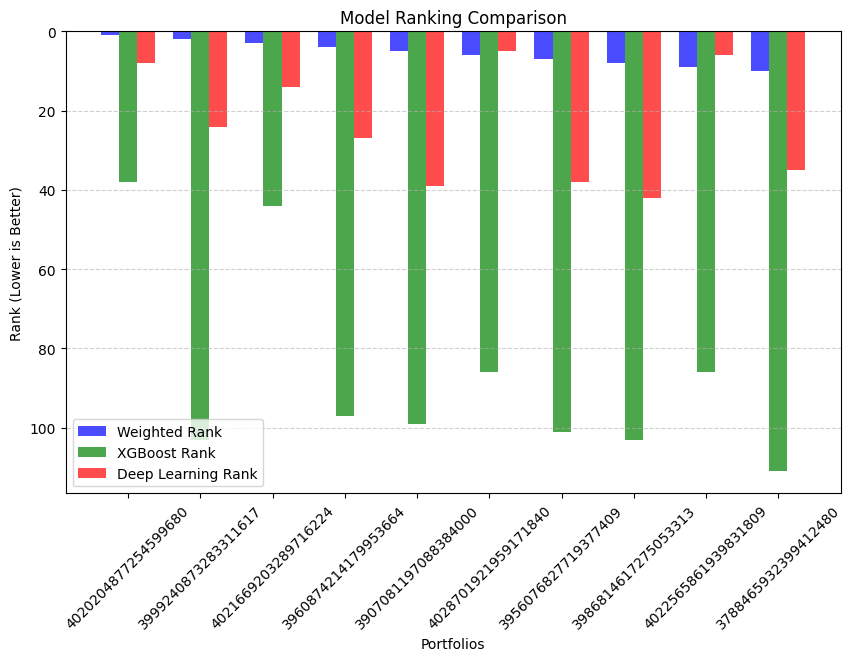

In [26]:
# Load data
#df_comparison = pd.read_csv("ranking_comparison_with_metrics.csv")

# Sort by Weighted Rank for better visualization
df_comparison = df_comparison.sort_values(by="Weighted_Rank", ascending=True)

# Take top 10 portfolios for clarity
df_top = df_comparison.head(10)

# Set positions for bars
x = np.arange(len(df_top))
width = 0.25  # Adjusted for even spacing

# Initialize figure
plt.figure(figsize=(10, 6))

# Create grouped bar chart
plt.bar(x - width, df_top["Weighted_Rank"], width=width, label="Weighted Rank", color="blue", alpha=0.7)
plt.bar(x, df_top["XGBoost_Rank"], width=width, label="XGBoost Rank", color="green", alpha=0.7)
plt.bar(x + width, df_top["DeepLearning_Rank"], width=width, label="Deep Learning Rank", color="red", alpha=0.7)

# Invert y-axis (Lower Rank = Better)
plt.gca().invert_yaxis()

# Labeling
plt.xticks(x, df_top["Port_IDs"], rotation=45)
plt.xlabel("Portfolios")
plt.ylabel("Rank (Lower is Better)")
plt.title("Model Ranking Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show plot
plt.show()

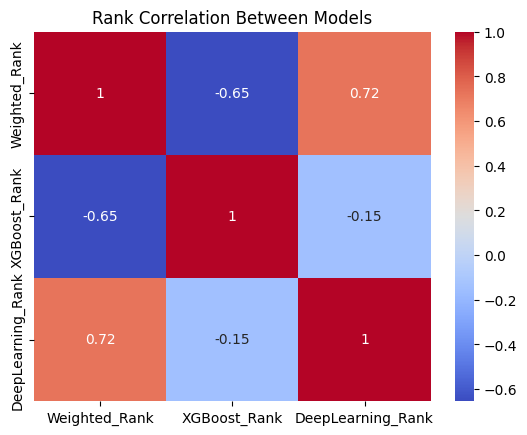

In [27]:
sns.heatmap(df_comparison[["Weighted_Rank", "XGBoost_Rank", "DeepLearning_Rank"]].corr(), annot=True, cmap="coolwarm")
plt.title("Rank Correlation Between Models")
plt.show()


## CONCLUSION

Summary of Approaches


*   Weighted Ranking: A simple heuristic-based approach that assigns weights to financial metrics.
  **Simplicity and speed**, the Weighted Ranking approach is the easiest to implement but may lack predictive power.

*  XGBoost Pairwise Ranking: Uses a machine learning model with a ranking objective to predict ranks. **Interpretability-wise**, XGBoost is a better choice since it provides feature importance, making it useful for understanding key drivers of rankings.


* Deep Learning Pairwise Ranking: Implements a neural network trained with a custom pairwise ranking loss. **Performance-wise**, the deep learning model has the highest potential to learn complex ranking relationships.

